In [1]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 3.3MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5269 sha256=691fcebe775775aea1acb79d9c7fb4c19b761e76a6f7a4f3dd9baa50f987da19
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [0]:
import copy
import time
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

import torch.nn as nn
import torch

In [0]:
def load_data(data_folder, batch_size, phase='train', train_val_split=True, train_ratio=.2):
    transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.RandomCrop(224),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ])}

    data = torchvision.datasets.ImageFolder(root=data_folder, transform=transform_dict[phase])

    train_size = int(train_ratio * len(data))
    test_size = len(data) - train_size
    data_size = {"train":train_size, "val":test_size}

    data_train, data_val = torch.utils.data.random_split(data, [train_size, test_size])
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True,
                                            num_workers=1)
    val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=False, drop_last=False,
                                        num_workers=1)
    dataloaders={"train":train_loader, "val":val_loader}
    return dataloaders, data_size


In [0]:
!unzip /content/pics.zip -d /content/data > /dev/null 2>&1 &

In [0]:
dataloaders, data_size = load_data("/content/data/pics", 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


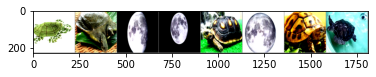

tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0)


In [6]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
# 訓練データをランダムに取得
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()

# 画像の表示

imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % labels[labels[j]] for j in range(8)))

In [7]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
for p in model.parameters():
    p.requires_grad=True
model.fc = nn.Linear(512, 2)

In [0]:
model = model.cuda()#GPUを使用しない場合はこの行はいらない。
lr = 1e-4
epoch = 40
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().cuda() 

In [10]:
torch.cuda.is_available()

True

In [0]:
use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_dict ={"train" : [],  "val" : []}
    acc_dict = {"train" : [],  "val" : []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        # 各エポックで訓練+バリデーションを実行
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)   # training mode
            else:
                model.train(False)  # evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                # else:
                #     inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)


            # サンプル数で割って平均を求める
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.item() / data_size[phase]
            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            # 精度が改善したらモデルを保存する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict, acc_dict

In [12]:
model_ft, loss, acc = train_model(model, criterion, optim, num_epochs=epoch)

Epoch 0/40
----------
train Loss: 0.4456 Acc: 0.6071


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1404 Acc: 0.9737
Epoch 1/40
----------
train Loss: 0.1955 Acc: 0.7857


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0677 Acc: 0.9825
Epoch 2/40
----------
train Loss: 0.0578 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0830 Acc: 0.9737
Epoch 3/40
----------
train Loss: 0.0079 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0755 Acc: 0.9737
Epoch 4/40
----------
train Loss: 0.0066 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0678 Acc: 0.9825
Epoch 5/40
----------
train Loss: 0.0127 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0628 Acc: 0.9825
Epoch 6/40
----------
train Loss: 0.1031 Acc: 0.8214


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0558 Acc: 0.9825
Epoch 7/40
----------
train Loss: 0.0268 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0283 Acc: 0.9912
Epoch 8/40
----------
train Loss: 0.0045 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0286 Acc: 0.9912
Epoch 9/40
----------
train Loss: 0.0067 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0227 Acc: 1.0000
Epoch 10/40
----------
train Loss: 0.0011 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0260 Acc: 0.9912
Epoch 11/40
----------
train Loss: 0.0063 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0158 Acc: 1.0000
Epoch 12/40
----------
train Loss: 0.0012 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0167 Acc: 1.0000
Epoch 13/40
----------
train Loss: 0.0453 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0208 Acc: 1.0000
Epoch 14/40
----------
train Loss: 0.0019 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0168 Acc: 1.0000
Epoch 15/40
----------
train Loss: 0.0009 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0170 Acc: 1.0000
Epoch 16/40
----------
train Loss: 0.0041 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0236 Acc: 1.0000
Epoch 17/40
----------
train Loss: 0.0020 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0177 Acc: 1.0000
Epoch 18/40
----------
train Loss: 0.0033 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0176 Acc: 1.0000
Epoch 19/40
----------
train Loss: 0.0004 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0273 Acc: 0.9912
Epoch 20/40
----------
train Loss: 0.0015 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0250 Acc: 1.0000
Epoch 21/40
----------
train Loss: 0.0082 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0347 Acc: 0.9912
Epoch 22/40
----------
train Loss: 0.0005 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0182 Acc: 1.0000
Epoch 23/40
----------
train Loss: 0.0013 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0211 Acc: 1.0000
Epoch 24/40
----------
train Loss: 0.0003 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0190 Acc: 1.0000
Epoch 25/40
----------
train Loss: 0.0006 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0195 Acc: 1.0000
Epoch 26/40
----------
train Loss: 0.0183 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0235 Acc: 0.9912
Epoch 27/40
----------
train Loss: 0.0005 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0203 Acc: 0.9912
Epoch 28/40
----------
train Loss: 0.0002 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0163 Acc: 1.0000
Epoch 29/40
----------
train Loss: 0.0017 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0296 Acc: 0.9912
Epoch 30/40
----------
train Loss: 0.0045 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0244 Acc: 0.9912
Epoch 31/40
----------
train Loss: 0.0020 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0234 Acc: 1.0000
Epoch 32/40
----------
train Loss: 0.0023 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0277 Acc: 0.9912
Epoch 33/40
----------
train Loss: 0.0004 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0284 Acc: 0.9912
Epoch 34/40
----------
train Loss: 0.0004 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0231 Acc: 1.0000
Epoch 35/40
----------
train Loss: 0.0450 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0773 Acc: 0.9737
Epoch 36/40
----------
train Loss: 0.0023 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0668 Acc: 0.9737
Epoch 37/40
----------
train Loss: 0.0008 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0718 Acc: 0.9737
Epoch 38/40
----------
train Loss: 0.0017 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0577 Acc: 0.9737
Epoch 39/40
----------
train Loss: 0.0004 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0574 Acc: 0.9737
Training complete in 1m 17s
Best val acc: 1.0000


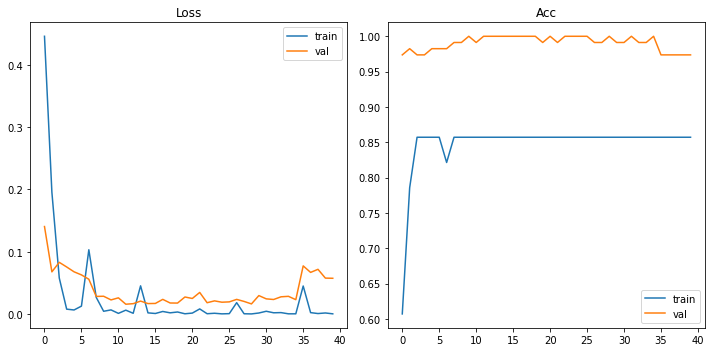

In [13]:
#loss, accを取り出します。
loss_train = loss["train"]
loss_val    = loss["val"]

acc_train = acc["train"]
acc_val    = acc["val"]


#このように書く事で、nrows x cols のグラフを作成する事ができます。
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#０個目のグラフ
axes[0].plot(range(epoch), loss_train, label = "train")
axes[0].plot(range(epoch), loss_val,    label =  "val")
axes[0].set_title("Loss")
axes[0].legend()#各グラフのlabelを表示

#１個目のグラフ
axes[1].plot(range(epoch), acc_train, label = "train")
axes[1].plot(range(epoch), acc_val,    label =  "val")
axes[1].set_title("Acc")
axes[1].legend()

#０個目と１個目のグラフが重ならないように調整
fig.tight_layout()


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")
modell = torch.nn.DataParallel(model).to(device)
# model.module.features
modell.module

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
model.parameters()

<generator object Module.parameters at 0x7f5ef6b2f1a8>

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
path_png = "/content/353.png"
path_jpg = "/content/353.jpeg"

image = Image.open(path_png).convert('P')
image.save(path_png)
rgb_im = Image.open(path_png).convert('RGB')
rgb_im.save(path_jpg)

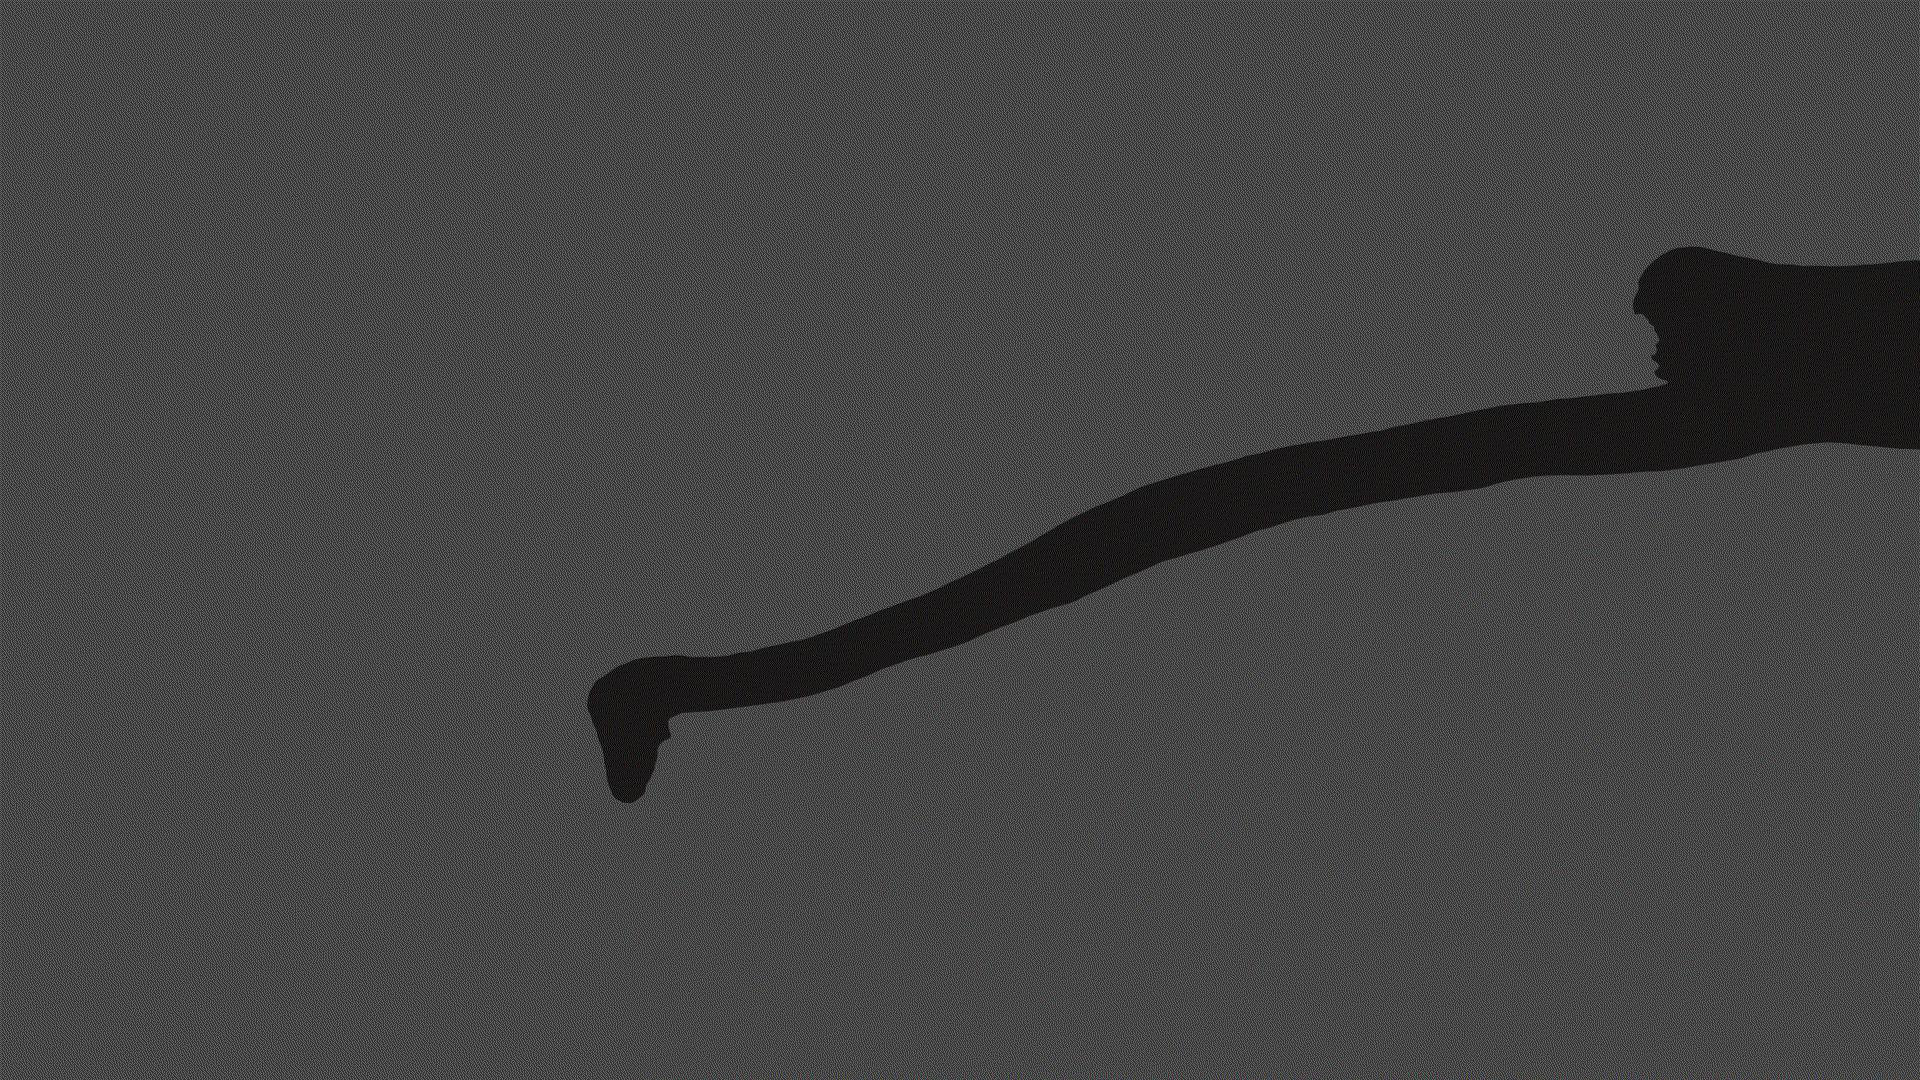

In [31]:
img_name = '/content/353.jpeg'
img_path = os.path.join(img_name)

pil_img = PIL.Image.open(img_path)
pil_img

In [0]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [0]:
resnet = model

In [0]:
configs = [
    dict(model_type='resnet', arch=resnet, layer_name='layer4')
]

In [0]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [36]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    # images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    images.extend([torch_img.cpu(), result_pp])
    
grid_image = make_grid(images, nrow=2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


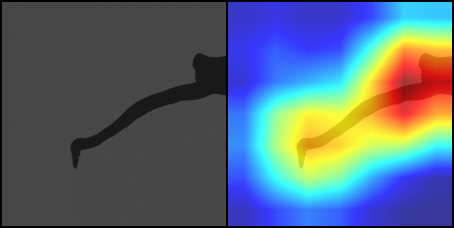

In [37]:
transforms.ToPILImage()(grid_image)